In [205]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel,SequentialFeatureSelector
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
import random
import time
import shap
import ipywidgets as widgets
import pickle
from IPython.display import display
from sklearn.metrics import PrecisionRecallDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import json
shap.initjs()
random.seed(42)

In [206]:
fpr_list = []
tpr_list = []
roc_auc_list = []

def load_config(path='config.json'):
    with open(path, 'r') as file:
        return json.load(file)

def Curve(y_test,y_prob) -> None:
    # Compute the ROC curve and AUROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
   
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random classifier line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
def Matrix(y_test,y_pred) -> None:
    # Compute and plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    plt.close()

def Precision_Recall(classifier, X_test, y_test) -> None:
    display = PrecisionRecallDisplay.from_estimator(
        classifier, X_test, y_test, name="LinearSVC", plot_chance_level=True
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")

Dropped varialbes:  ['wbc_avg', 'lactate_avg', 'ferritin_avg', 'fibrin_avg', 'crp_avg', 'neutrophil_count_avg', 'lymphocyte_count_avg', 'neutrophil_lymphocyte_ratio', 'fio2_avg', 'pao2_fio2_ratio', 'platelets_avg', 'sofa_respiratory_score', 'sofa_coagulation_score', 'sofa_neurological_score', 'death_date', 'died_within_30_days_of_ecmo']


C:\Users\m171548\AppData\Local\Temp\ipykernel_20124\4018269533.py:25: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



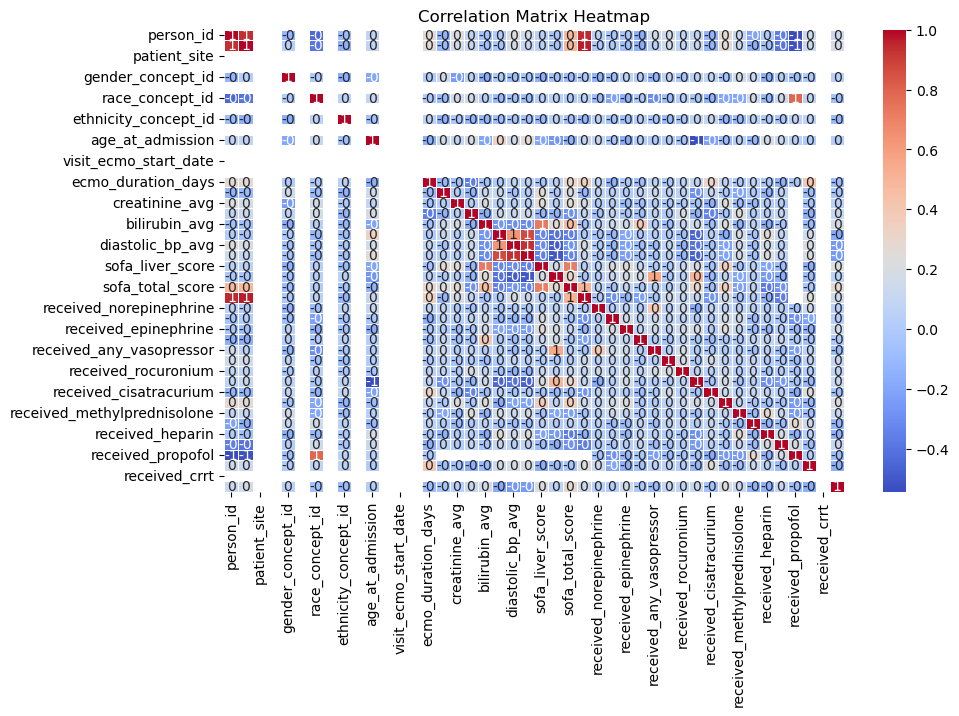

In [219]:
## import DataFrame
random.seed(42)
df = pd.read_csv('rediscover_ecmo_vv_v3.csv')
df = df.drop(columns =[])
encoder = LabelEncoder()
'''
## Applying binary map (Just in case)
binary_map = {'Yes': 1, 'No': 0}
for col in df.select_dtypes(include=['object']).columns:
    unique_vals = df[col].dropna().unique()
    if set(unique_vals).issubset(set(binary_map.keys())):
        print(f"Mapping binary column: {col}")
        df[col] = df[col].map(binary_map)
        '''

# Remove incomplete columns
dropped = []
for header, series in df.items():
    if (series.isnull().sum())/len(series) > 0.1:
        dropped.append(header)
        df = df.drop(columns = header)
print("Dropped varialbes: ",dropped) 

# Apply label encoding to each column of the DataFrame
df = df.applymap(lambda x: encoder.fit_transform([x])[0] if isinstance(x, str) else x)
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',fmt=".0f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.savefig("heatmap.png")
plt.show()


## X and y
X = df.drop(columns = ['died'])
y = df['died']

## Impute missing variables
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns = X.columns)

## Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)


Top Features:  ['map_avg', 'visit_occurrence_id', 'sofa_total_score', 'diastolic_bp_avg', 'systolic_bp_avg', 'age_at_admission', 'bilirubin_avg', 'received_fentanyl']
Top features based on SHAP:
                 feature  shap_importance
21              map_avg         0.034150
1   visit_occurrence_id         0.029078
24     sofa_total_score         0.026564
20     diastolic_bp_avg         0.026098
19      systolic_bp_avg         0.025183
10     age_at_admission         0.023397
18        bilirubin_avg         0.022371
39    received_fentanyl         0.019933


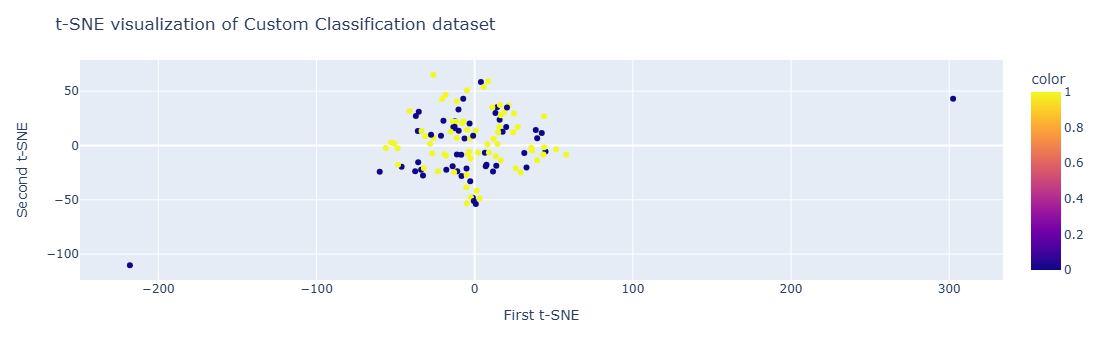

In [220]:
### Feature Selection using SHAP
random.seed(42)
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
# --------  Train Gradient Boosting Classifier  --------
#xgb_model = GradientBoostingClassifier(n_estimators = 100, random_state = 42)
#xgb_model.fit(X_train, y_train)

# --------  SHAP Explanation --------
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_train,check_additivity=False)  # This gives a (n_samples, n_features, 2) for binary classification

# --------  Extract SHAP Values for Class 1 --------
shap_values_class1 = shap_values.values[:, :, 1]  # shape: (n_samples, n_features)

# --------  Compute SHAP Importance --------
shap_importance = np.abs(shap_values_class1).mean(axis=0)  # shape: (n_features,)

# --------  Build Feature Importance Table --------
feature_importance_df = pd.DataFrame({
    'feature': shap_values.feature_names,
    'shap_importance': shap_importance
}).sort_values(by='shap_importance', ascending=False)

# --------  Select Top K Features --------
top_k = 8
top_features = feature_importance_df['feature'].head(top_k).tolist()
print("Top Features: ", top_features)
print("Top features based on SHAP:\n", feature_importance_df.head(top_k))

# --------  Reduce X to Top Features --------

X = df[top_features]
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns = X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)


### t-distributed stochastic neighbor embedding (TSNE)
X_embedded = TSNE(n_components = 3, learning_rate = 'auto', init = 'random', perplexity = 3).fit_transform(X_train)
X_embedded.shape

fig = px.scatter(x = X_embedded[:, 0], y = X_embedded[:, 1], color = y_train)
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

Performing Nested Cross-Validation...
Nested CV completed in 0.40 seconds
Nested Cross-Validated ROC AUC Score: 0.69 ± 0.09

Training final model on full training set...
Best Hyperparameters: {'svm__gamma': 'scale', 'svm__C': 0.1}

Evaluating on Test Set...

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.70      0.60        23
           1       0.70      0.53      0.60        30

    accuracy                           0.60        53
   macro avg       0.61      0.61      0.60        53
weighted avg       0.63      0.60      0.60        53

Accuracy Score: 0.6037735849056604
Test Set ROC AUC Score: 0.6811594202898551


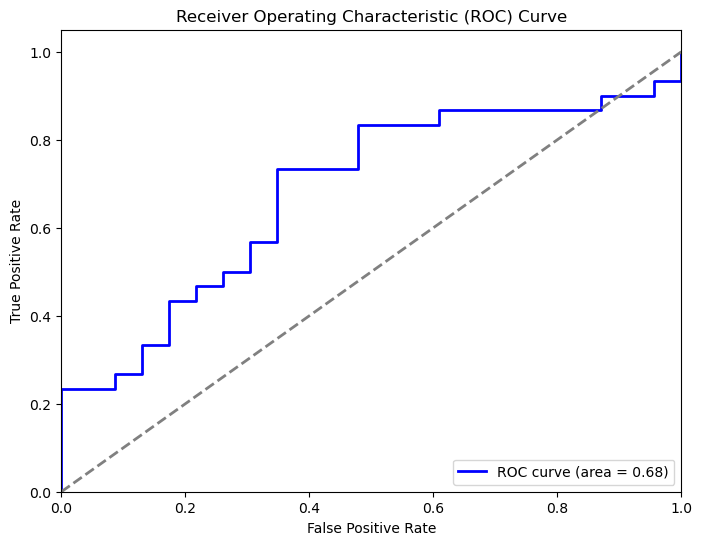

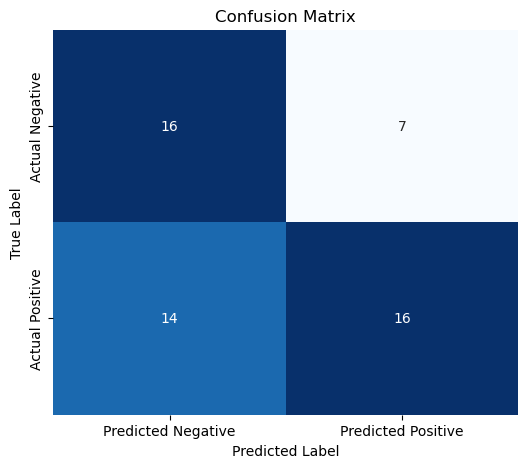

AUROC: 0.68
Setting Kernel Explainer
Setting Sample Data
Setting SHAP Values


C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\m171548\AppData\Local

Plotting SHAP summary
(53, 8)
(53, 8)


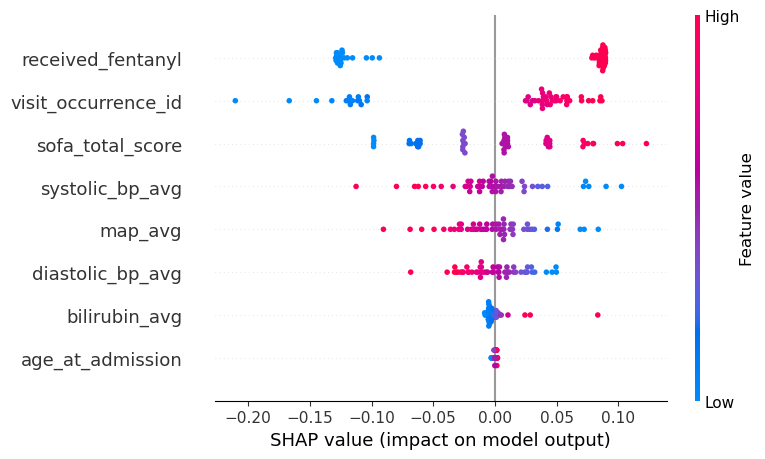

Plotting SHAP values for each feature

Generating SHAP dependence plot for feature: map_avg


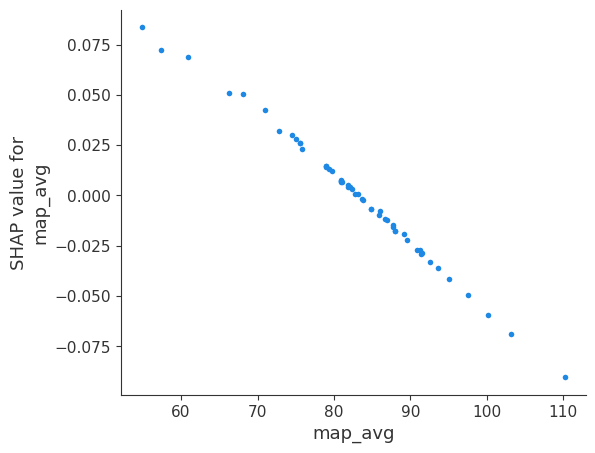


Generating SHAP dependence plot for feature: visit_occurrence_id


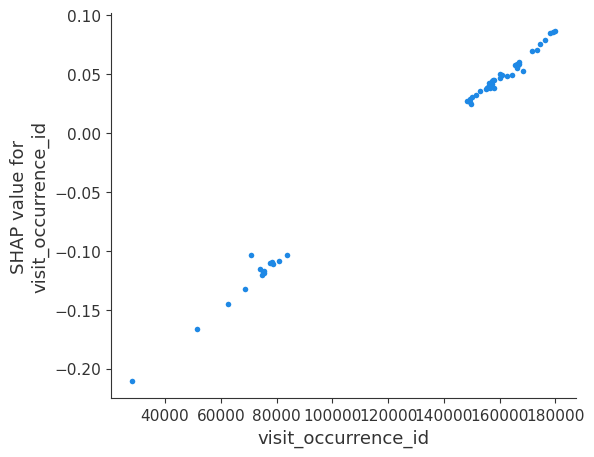


Generating SHAP dependence plot for feature: sofa_total_score


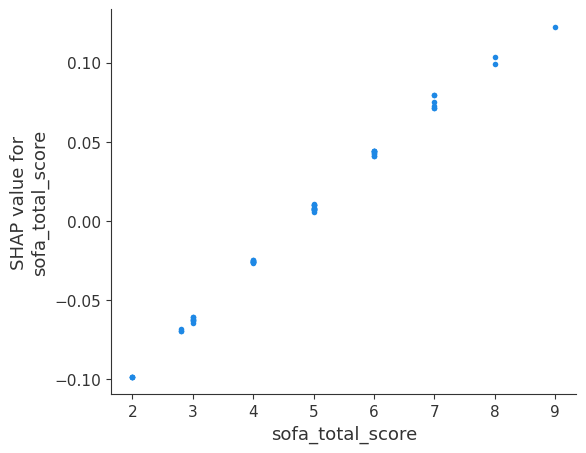


Generating SHAP dependence plot for feature: diastolic_bp_avg


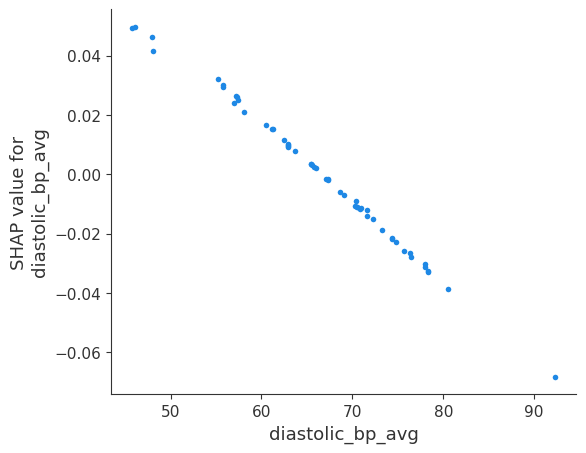


Generating SHAP dependence plot for feature: systolic_bp_avg


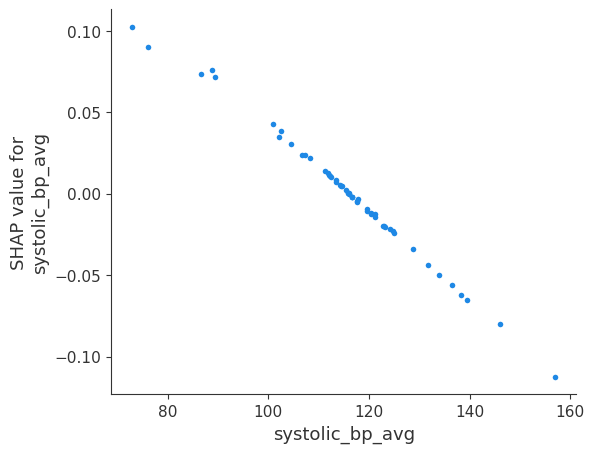


Generating SHAP dependence plot for feature: age_at_admission


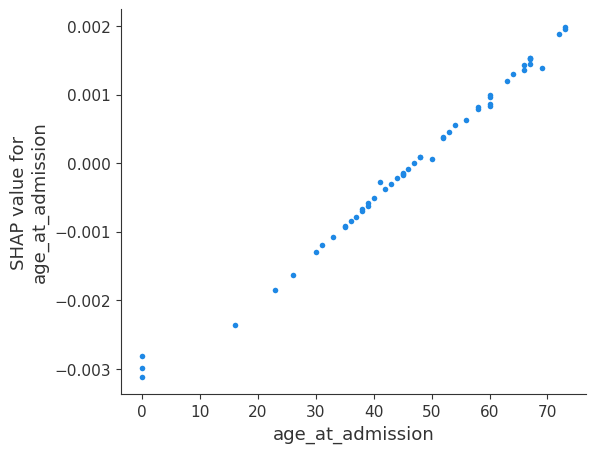


Generating SHAP dependence plot for feature: bilirubin_avg


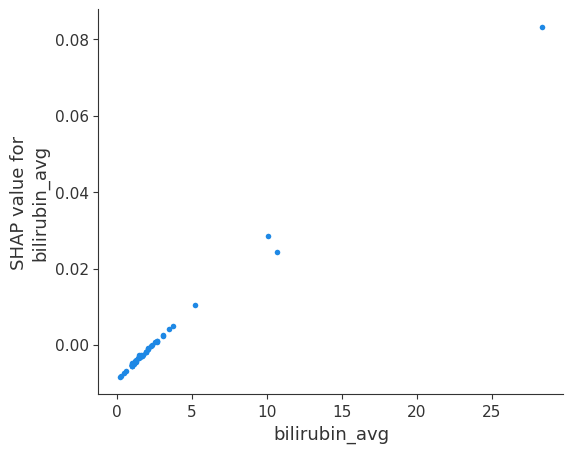


Generating SHAP dependence plot for feature: received_fentanyl


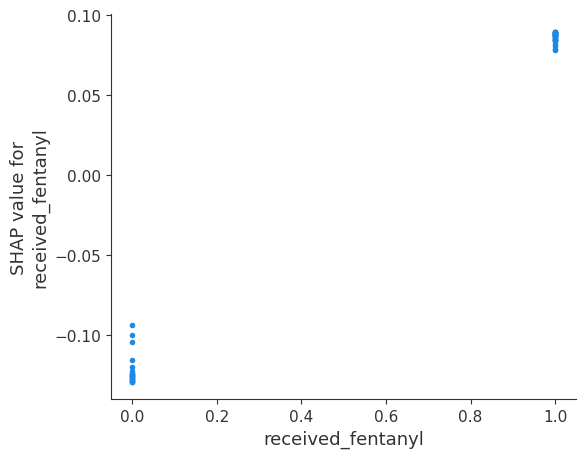

In [209]:
random.seed(42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scaling
    ('svm', SVC(kernel='linear', probability = True, class_weight = 'balanced'))  # Step 3: SVM Model 
])

# Define parameter grid for hyperparameter tuning    
param_grid = {
    'svm__C': [0.1,1,10],  # SVM's C parameter
    'svm__gamma': ['scale', 'auto']  # SVM's gamma parameter
}

# Perform nested cross-validation to estimate generalization performance
print("Performing Nested Cross-Validation...")
start = time.time()

# Outer CV: Evaluating generalization performance

nested_scores = cross_val_score(
    RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=6),
    X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
end = time.time()
print(f"Nested CV completed in {end - start:.2f} seconds")
print("Nested Cross-Validated ROC AUC Score: %.2f ± %.2f" % (nested_scores.mean(), nested_scores.std()))


# Best model from grid search
end = time.time()
# Now train the final model on the full training data
print("\nTraining final model on full training set...")
grid_search = RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=6)
grid_search.fit(X_train, y_train)
best_pipeline = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Test set evaluation
print("\nEvaluating on Test Set...")
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Test Set ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Optional: Plotting (assuming you have Curve and Matrix functions)
Curve(y_test, y_prob)
Matrix(y_test, y_pred)
Precision_Recall(best_pipeline, X_test, y_test)
plt.close()

###############################################
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)
best_roc_auc = roc_auc
print(f"AUROC: %0.2f"%roc_auc)
pickle_model = best_pipeline
best_y_pred = y_pred
best_y_prob = y_prob
best_classifier = best_pipeline.named_steps['svm']

# Add SHAP value table
svm_model = best_pipeline.named_steps['svm']
# Select X
best_X_train = X_train
best_X_test = X_test

# Create the SHAP explainer. Since SVM is a non-tree-based model, we can use the KernelExplainer.
def pipeline_predict(X_test):
    return best_pipeline.predict_proba(X_test)

# Sample 100 instances for KernelExplainer background set
background = shap.sample(X_test, 100)

# Use full pipeline for predictions
print("Setting Kernel Explainer")
explainer = shap.KernelExplainer(pipeline_predict, background)

# Use a smaller sample for SHAP calculation (to keep it fast)
print("Setting Sample Data")
sample_data = X_test.iloc[:200]

# Compute SHAP values
print("Setting SHAP Values")
shap_values = explainer.shap_values(sample_data)

# Plot SHAP summary plot (for class 0 or 1; pick class 1 for binary classification)
print("Plotting SHAP summary")
print(shap_values[:,:,1].shape)
print(sample_data.shape)
shap.summary_plot(shap_values[:,:,1], sample_data)
plt.close()

# Optional: Dependence plots
print("Plotting SHAP values for each feature")
for feature in top_features:
    print(f"\nGenerating SHAP dependence plot for feature: {feature}")
    shap.dependence_plot(
        feature,
        shap_values[:,:,1],
        sample_data,
        interaction_index=None,
        show=True
    )

Performing Nested Cross-Validation...
Nested CV completed in 8.04 seconds
Nested Cross-Validated ROC AUC Score: 0.64 ± 0.07

Training final model on full training set...


C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:861: UserWarning:

class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.



Best Hyperparameters: {'rf__warm_start': True, 'rf__n_estimators': 10, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 10, 'rf__max_depth': None, 'rf__criterion': 'gini', 'rf__bootstrap': True}

Evaluating on Test Set...

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.39      0.43        23
           1       0.59      0.67      0.62        30

    accuracy                           0.55        53
   macro avg       0.53      0.53      0.53        53
weighted avg       0.54      0.55      0.54        53

Accuracy Score: 0.5471698113207547
Test Set ROC AUC Score: 0.5978260869565217


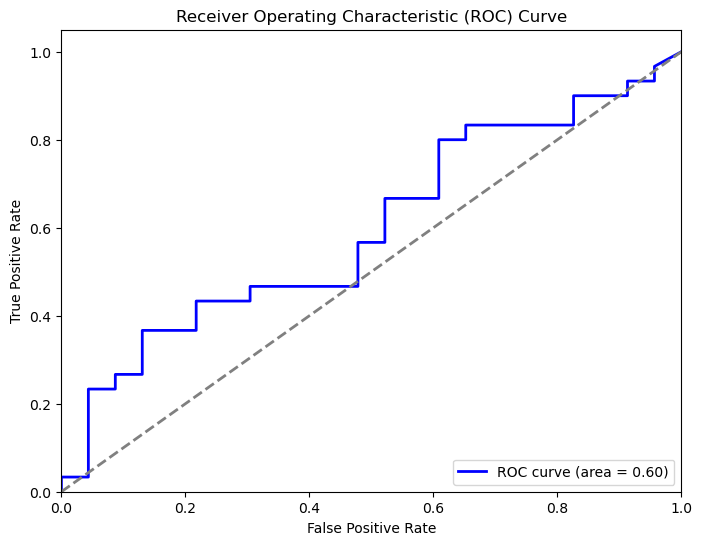

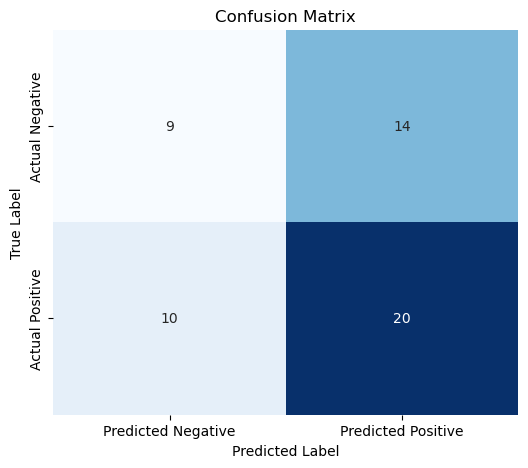

AUROC: 0.60
Setting Tree Explainer
Setting Sample Data
Setting SHAP Values
Plotting SHAP summary
(53, 8)
(53, 8)


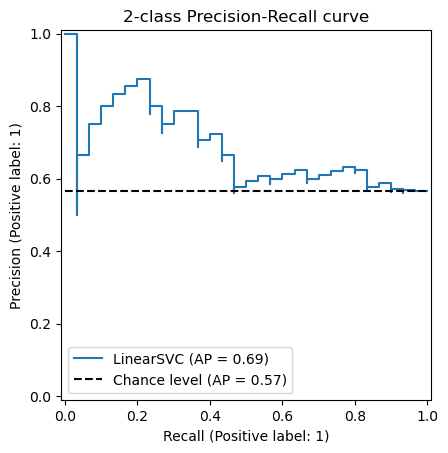

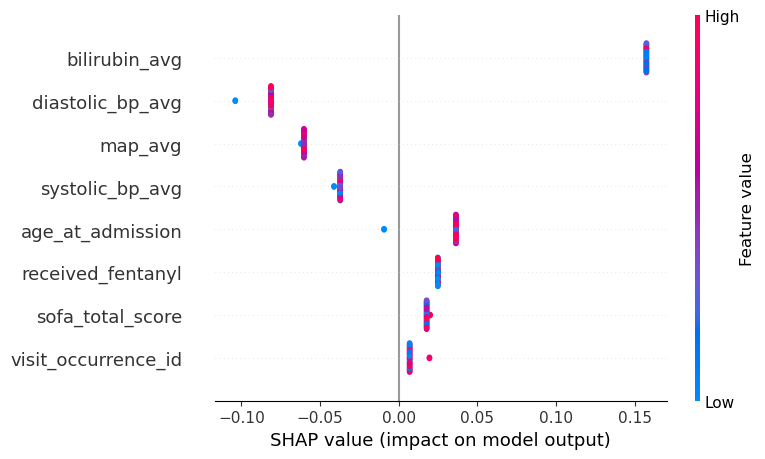

Plotting SHAP values for each feature

Generating SHAP dependence plot for feature: map_avg


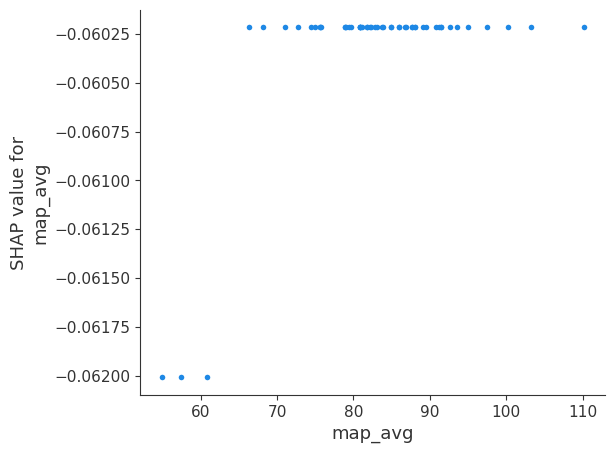


Generating SHAP dependence plot for feature: visit_occurrence_id


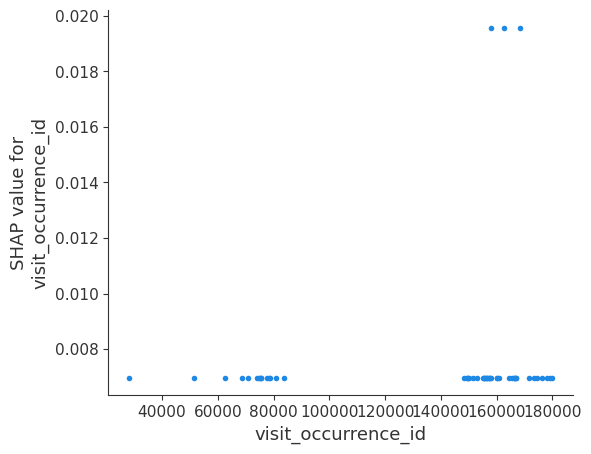


Generating SHAP dependence plot for feature: sofa_total_score


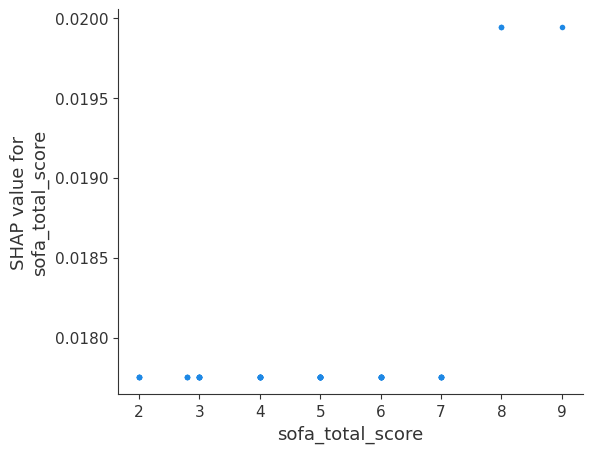


Generating SHAP dependence plot for feature: diastolic_bp_avg


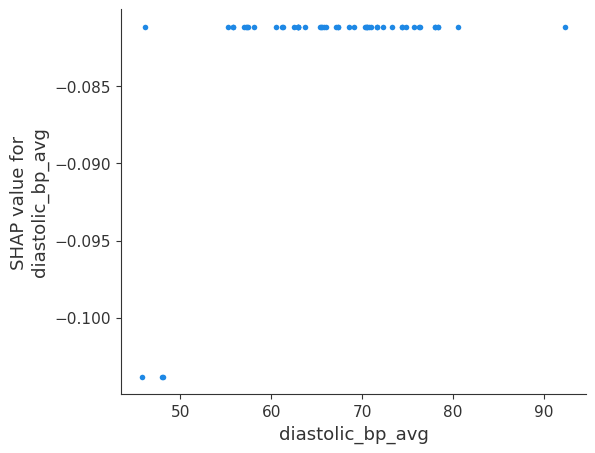


Generating SHAP dependence plot for feature: systolic_bp_avg


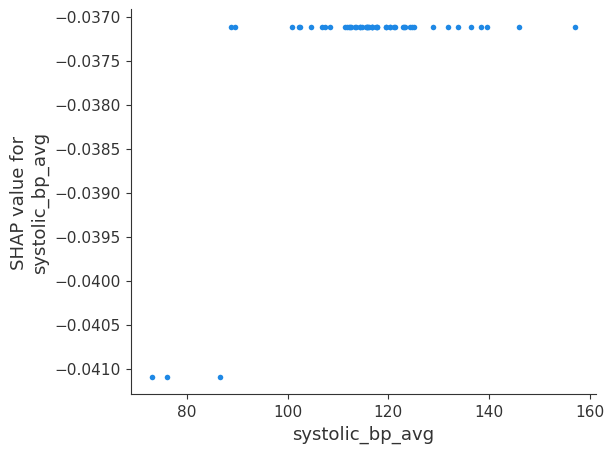


Generating SHAP dependence plot for feature: age_at_admission


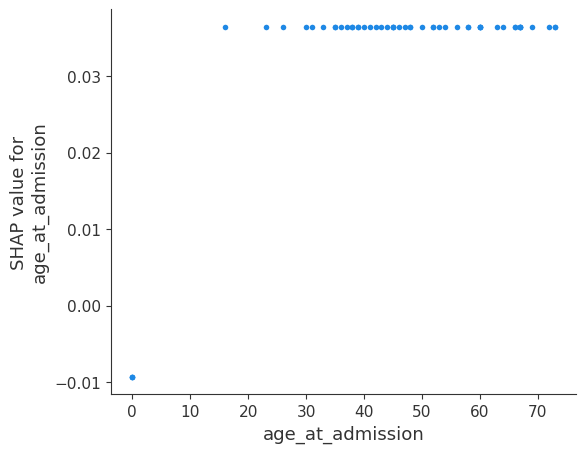


Generating SHAP dependence plot for feature: bilirubin_avg


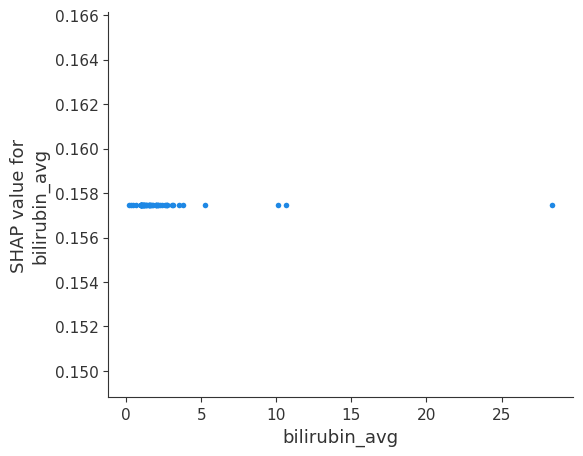


Generating SHAP dependence plot for feature: received_fentanyl


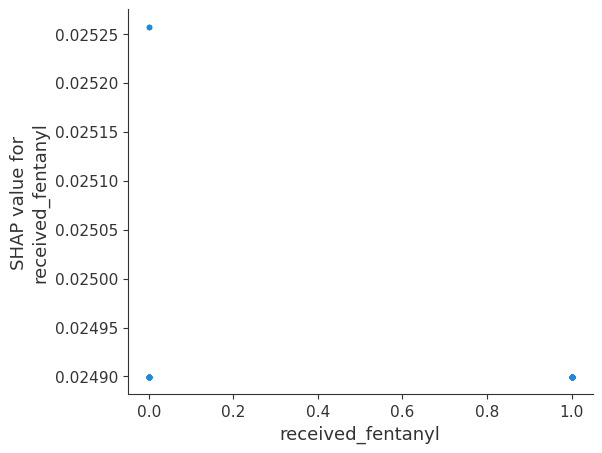

In [210]:
random.seed(42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scaling
    ('rf', RandomForestClassifier(class_weight = 'balanced'))  # Step 3: RandomForest Model 
])
# Define parameter grid for hyperparameter tuning    
param_grid = {
    'rf__n_estimators': [10, 50, 100, 200, 300, 500],  # RandomForest hyperparameters
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 5, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4, 10],
    'rf__bootstrap': [True, False],
    'rf__criterion': ['gini', 'entropy'],
    'rf__warm_start': [True, False],
}

# Perform nested cross-validation to estimate generalization performance
print("Performing Nested Cross-Validation...")
start = time.time()

# Outer CV: Evaluating generalization performance

nested_scores = cross_val_score(
    RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10),
    X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1
)

end = time.time()
print(f"Nested CV completed in {end - start:.2f} seconds")
print("Nested Cross-Validated ROC AUC Score: %.2f ± %.2f" % (nested_scores.mean(), nested_scores.std()))

# Best model from grid search
end = time.time()
# Now train the final model on the full training data
print("\nTraining final model on full training set...")
grid_search = RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10)
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)

# Test set evaluation
print("\nEvaluating on Test Set...")
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Test Set ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Optional: Plotting (assuming you have Curve and Matrix functions)
Curve(y_test, y_prob)
Matrix(y_test, y_pred)

###############################################
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)
print(f"AUROC: %0.2f"%roc_auc)

# Add shap value table
rf_model = best_pipeline.named_steps['rf']

Precision_Recall(best_pipeline, X_test, y_test)

if roc_auc > best_roc_auc:
    best_roc_auc = auc(fpr, tpr)
    pickle_model = best_pipeline
    best_y_pred = y_pred
    best_y_prob = y_prob
    best_classifier = best_pipeline.named_steps['rf']
    best_X_train = X_train
    best_X_test = X_test

# Sample 100 instances for KernelExplainer background set
background = shap.sample(X_test, 100)

# Use full pipeline for predictions
print("Setting Tree Explainer")
explainer = shap.TreeExplainer(best_pipeline.named_steps['rf'])

# Use a smaller sample for SHAP calculation (to keep it fast)
print("Setting Sample Data")
sample_data = X_test.iloc[:200]

# Compute SHAP values
print("Setting SHAP Values")
shap_values = explainer.shap_values(sample_data)

# Plot SHAP summary plot (for class 0 or 1; pick class 1 for binary classification)
print("Plotting SHAP summary")
print(shap_values[:,:,1].shape)
print(sample_data.shape)
plt.show()
shap.summary_plot(shap_values[:,:,1], sample_data)
plt.show()

# Optional: Dependence plots
print("Plotting SHAP values for each feature")
for feature in top_features:
    print(f"\nGenerating SHAP dependence plot for feature: {feature}")
    shap.dependence_plot(
        feature,
        shap_values[:,:,1],
        sample_data,
        interaction_index=None,
        show=True
    )

Performing Nested Cross-Validation...
Nested CV completed in 15.95 seconds
Nested Cross-Validated ROC AUC Score: 0.61 ± 0.05

Training final model on full training set...
Best Hyperparameters: {'xgb__warm_start': False, 'xgb__verbose': 0, 'xgb__validation_fraction': 0.2, 'xgb__subsample': 0.9, 'xgb__n_iter_no_change': 10, 'xgb__n_estimators': 200, 'xgb__min_samples_split': 10, 'xgb__min_samples_leaf': 10, 'xgb__max_leaf_nodes': 10, 'xgb__max_features': 'sqrt', 'xgb__max_depth': 6, 'xgb__learning_rate': 0.001, 'xgb__criterion': 'friedman_mse'}

Evaluating on Test Set...

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.57      1.00      0.72        30

    accuracy                           0.57        53
   macro avg       0.28      0.50      0.36        53
weighted avg       0.32      0.57      0.41        53

Accuracy Score: 0.5660377358490566
Test Set ROC AUC Score: 0.50797101449

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



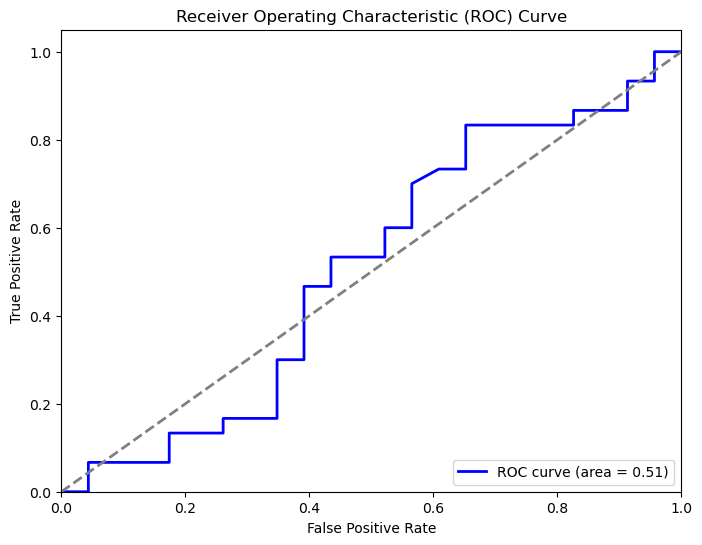

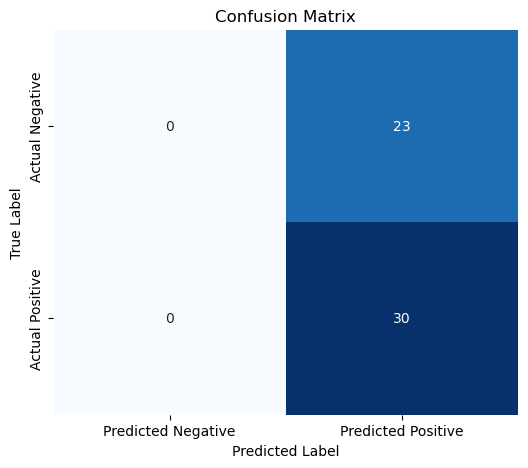

AUROC: 0.51
Setting Tree Explainer
Setting Sample Data
Setting SHAP Values
Plotting SHAP summary
(53, 8)
(53, 8)


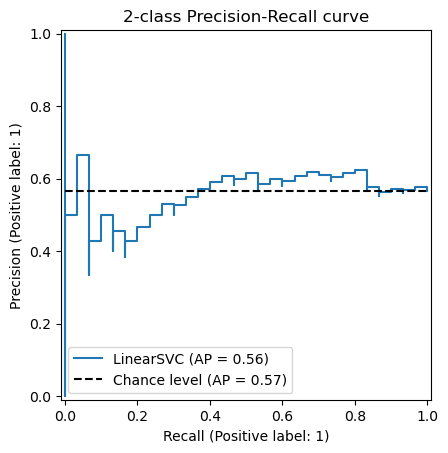

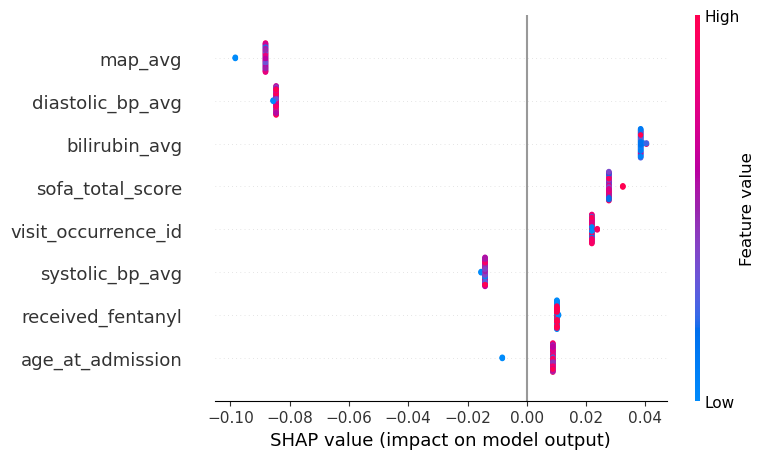

Plotting SHAP values for each feature

Generating SHAP dependence plot for feature: map_avg


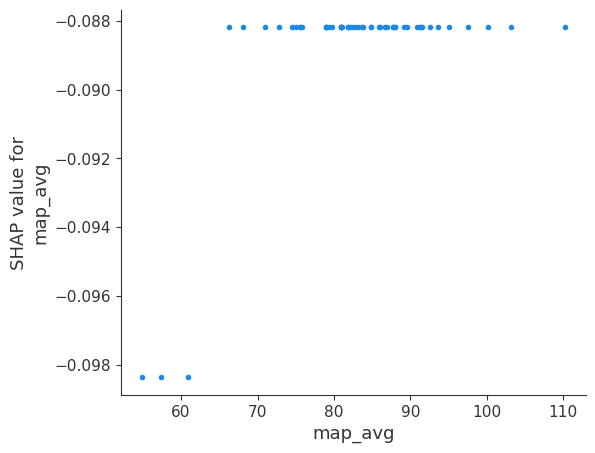


Generating SHAP dependence plot for feature: visit_occurrence_id


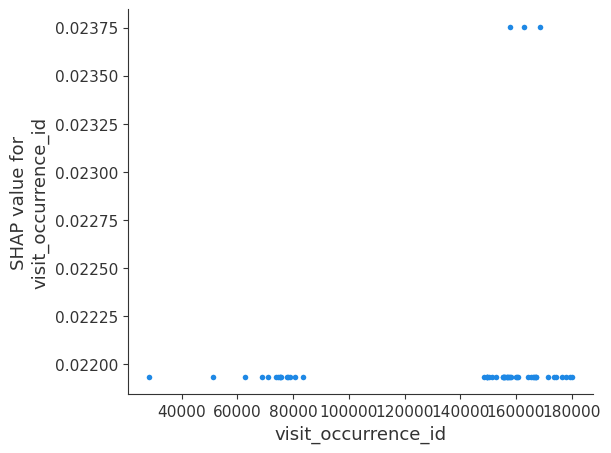


Generating SHAP dependence plot for feature: sofa_total_score


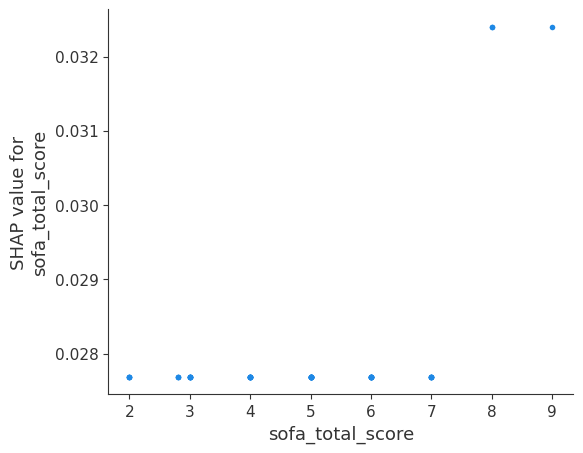


Generating SHAP dependence plot for feature: diastolic_bp_avg


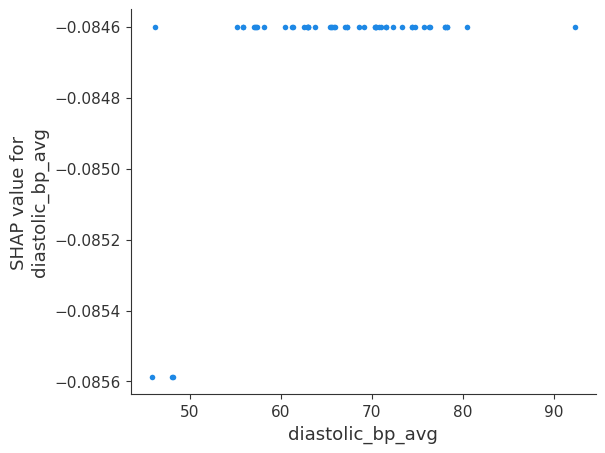


Generating SHAP dependence plot for feature: systolic_bp_avg


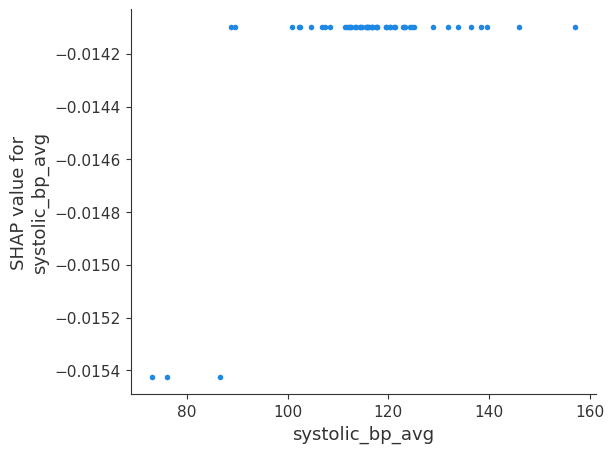


Generating SHAP dependence plot for feature: age_at_admission


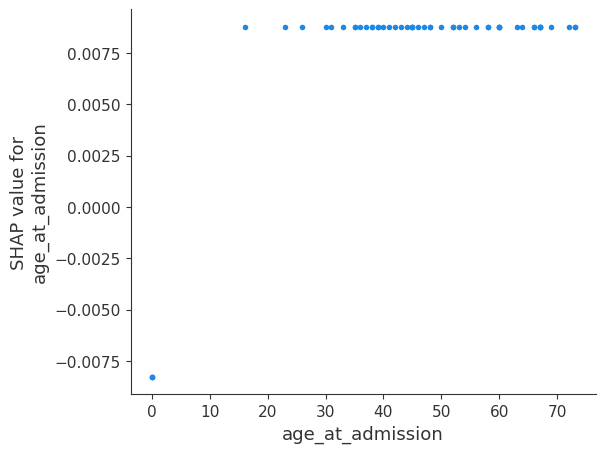


Generating SHAP dependence plot for feature: bilirubin_avg


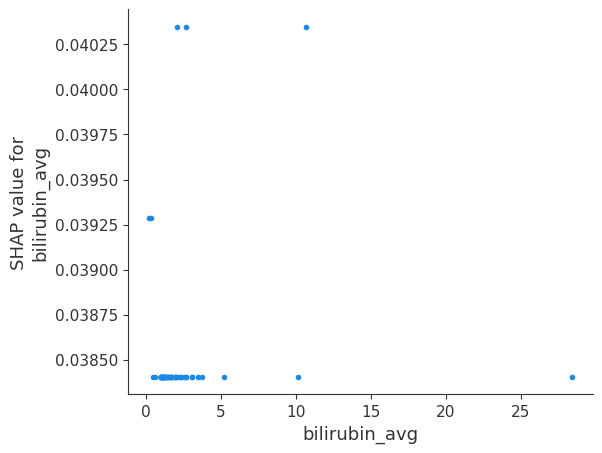


Generating SHAP dependence plot for feature: received_fentanyl


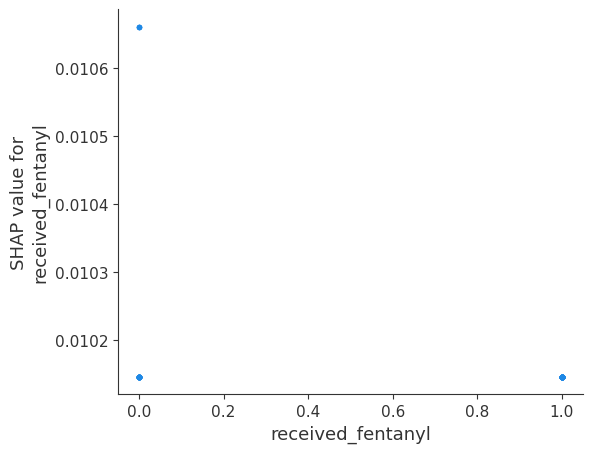

In [211]:
random.seed(42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scaling
    ('xgb', GradientBoostingClassifier())  # Step 3: XGBoost Model 
])

# Define parameter grid for hyperparameter tuning    
param_grid = {
    'xgb__n_estimators': [50, 100, 200, 300, 500],  # Number of boosting stages (trees)
    'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Step size shrinking to prevent overfitting
    'xgb__max_depth': [3, 4, 5, 6, 7],  # Maximum depth of the individual trees
    'xgb__min_samples_split': [2, 5, 10, 20],  # Minimum number of samples required to split an internal node
    'xgb__min_samples_leaf': [1, 2, 4, 10],  # Minimum number of samples required to be at a leaf node
    'xgb__subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting each base estimator (for stochastic gradient boosting)
    'xgb__max_features': ['sqrt', 'log2', None],  # The number of features to consider when splitting a node
    'xgb__criterion': ['friedman_mse', 'squared_error'],  # The loss function to optimize (Friedman MSE is the default)
    'xgb__verbose': [0, 1, 2],  # Controls the verbosity of the output during fitting
    'xgb__n_iter_no_change': [None, 10, 20],  # Number of iterations with no improvement before stopping the training
    'xgb__warm_start': [True, False],  # Whether to reuse the solution of the previous fit and add more estimators
    'xgb__max_leaf_nodes': [None, 10, 20, 50],  # Maximum number of leaf nodes in each tree
    'xgb__validation_fraction': [0.1, 0.2, 0.3],  # Proportion of training data to set aside for early stopping
}

# Perform nested cross-validation to estimate generalization performance
print("Performing Nested Cross-Validation...")
start = time.time()

nested_scores = cross_val_score(
    RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10),
    X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1
)
end = time.time()
print(f"Nested CV completed in {end - start:.2f} seconds")
print("Nested Cross-Validated ROC AUC Score: %.2f ± %.2f" % (nested_scores.mean(), nested_scores.std()))


# Best model from grid search
end = time.time()
# Now train the final model on the full training data
print("\nTraining final model on full training set...")
grid_search = RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10)
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)

# Test set evaluation
print("\nEvaluating on Test Set...")
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Test Set ROC AUC Score:", roc_auc_score(y_test, y_prob))

Curve(y_test, y_prob)
Matrix(y_test, y_pred)

###############################################
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)
print(f"AUROC: %0.2f"%roc_auc)

# Add shap value table
xgb_model = best_pipeline.named_steps['xgb']
Precision_Recall(best_pipeline, X_test, y_test)

if roc_auc > best_roc_auc:
    best_roc_auc = auc(fpr, tpr)
    pickle_model = best_pipeline
    best_y_pred = y_pred
    best_y_prob = y_prob
    best_classifier = best_pipeline.named_steps['xgb']
    best_X_train = X_train
    best_X_test = X_test


# Create the SHAP explainer.
# Use full pipeline for predictions
print("Setting Tree Explainer")
explainer = shap.TreeExplainer(best_pipeline.named_steps['xgb'])

# Use a smaller sample for SHAP calculation (to keep it fast)
print("Setting Sample Data")
sample_data = X_test.iloc[:200]

# Compute SHAP values
print("Setting SHAP Values")
shap_values = explainer.shap_values(sample_data)

# Plot SHAP summary plot (for class 0 or 1; pick class 1 for binary classification)
print("Plotting SHAP summary")
#print(shap_values[:,:,1].shape)
print(shap_values.shape)
print(sample_data.shape)
plt.show()
shap.summary_plot(shap_values, sample_data)
plt.show()

# Optional: Dependence plots
print("Plotting SHAP values for each feature")
for feature in top_features:
    print(f"\nGenerating SHAP dependence plot for feature: {feature}")
    shap.dependence_plot(
        feature,
        shap_values,
        sample_data,
        interaction_index=None,
        show=True
    )

Performing Nested Cross-Validation...
Nested CV completed in 12.38 seconds
Nested Cross-Validated ROC AUC Score: 0.62 ± 0.12

Training final model on full training set...
Best Hyperparameters: {'mlp__solver': 'adam', 'mlp__max_iter': 200, 'mlp__learning_rate_init': 0.01, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (100,), 'mlp__early_stopping': True, 'mlp__alpha': 0.0001, 'mlp__activation': 'tanh'}

Evaluating on Test Set...

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.48      0.52        23
           1       0.65      0.73      0.69        30

    accuracy                           0.62        53
   macro avg       0.61      0.61      0.61        53
weighted avg       0.62      0.62      0.62        53

Accuracy Score: 0.6226415094339622
Test Set ROC AUC Score: 0.7072463768115943


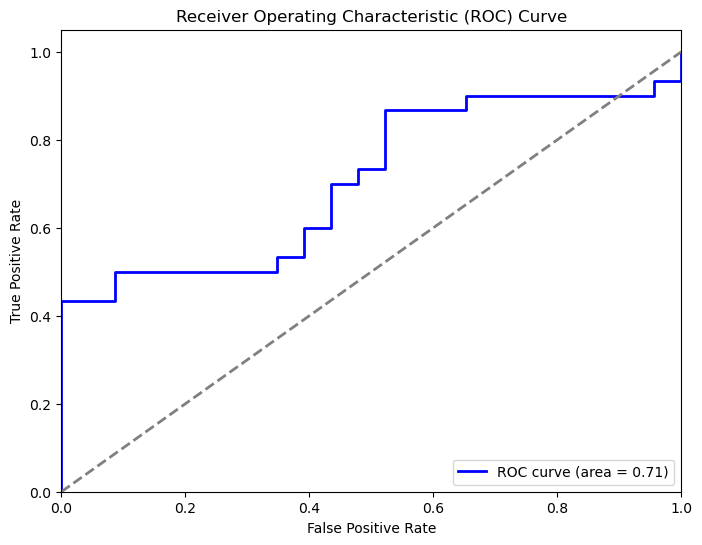

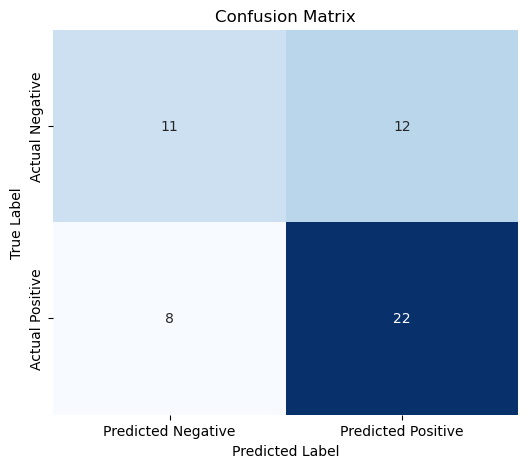

AUROC: 0.71
Setting Kernel Explainer
Setting Sample Data
Setting SHAP Values


C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



  0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

C:\Users\m171548\AppData\Local

Plotting SHAP summary
(53, 8)
(53, 8)


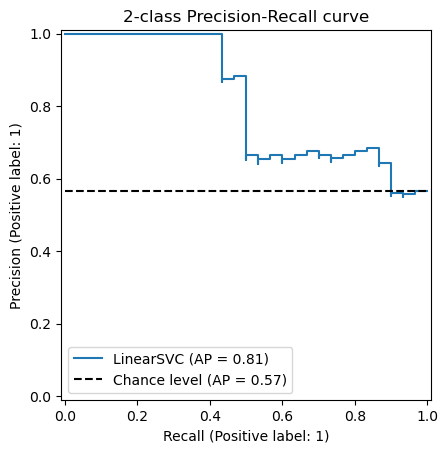

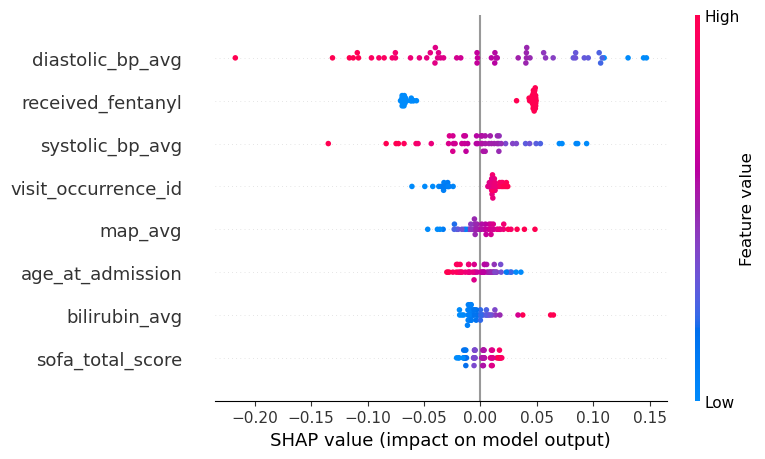

Plotting SHAP values for each feature

Generating SHAP dependence plot for feature: map_avg


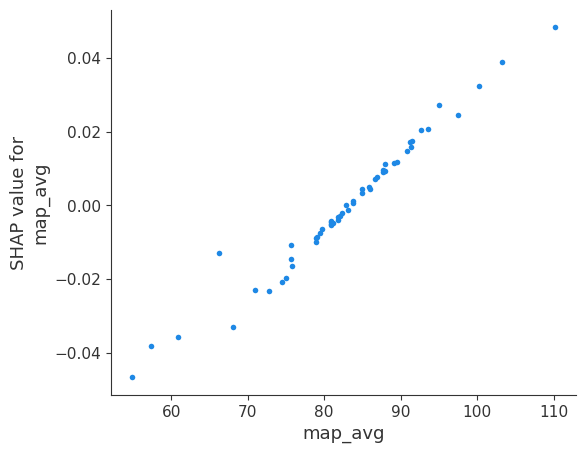


Generating SHAP dependence plot for feature: visit_occurrence_id


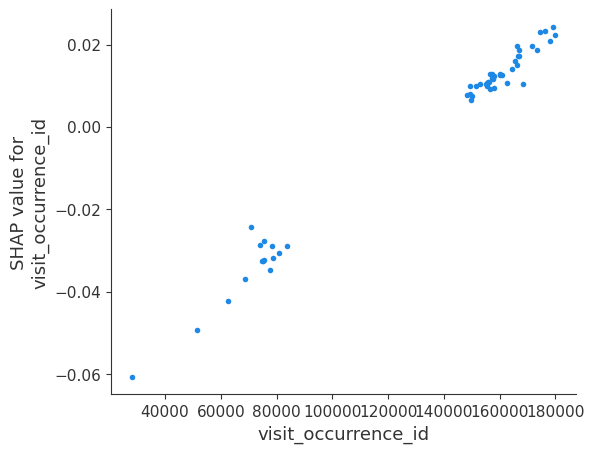


Generating SHAP dependence plot for feature: sofa_total_score


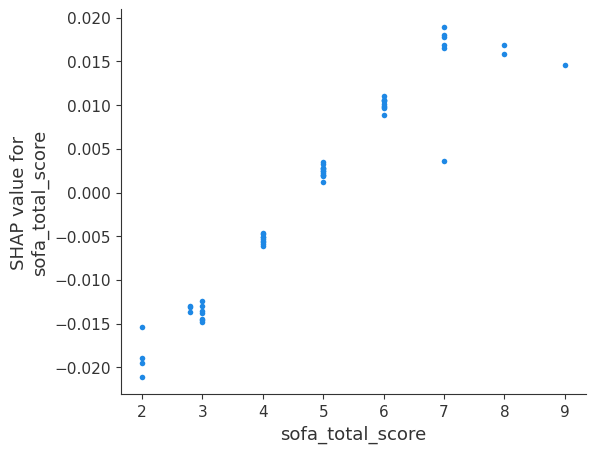


Generating SHAP dependence plot for feature: diastolic_bp_avg


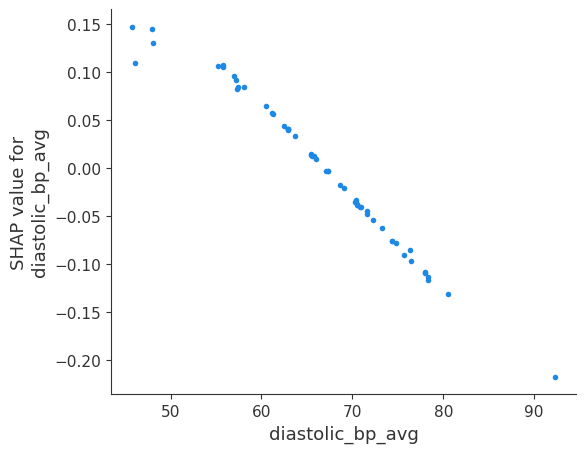


Generating SHAP dependence plot for feature: systolic_bp_avg


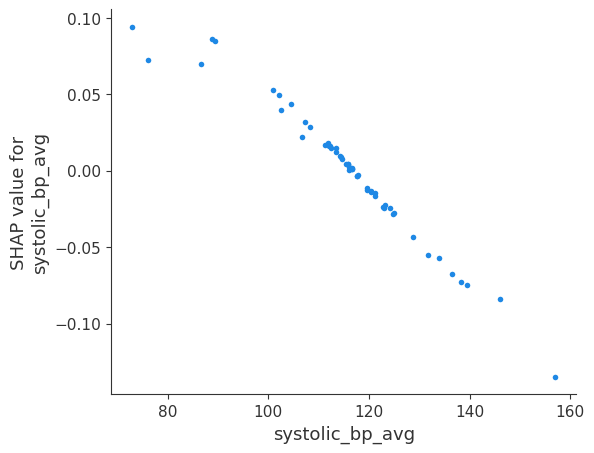


Generating SHAP dependence plot for feature: age_at_admission


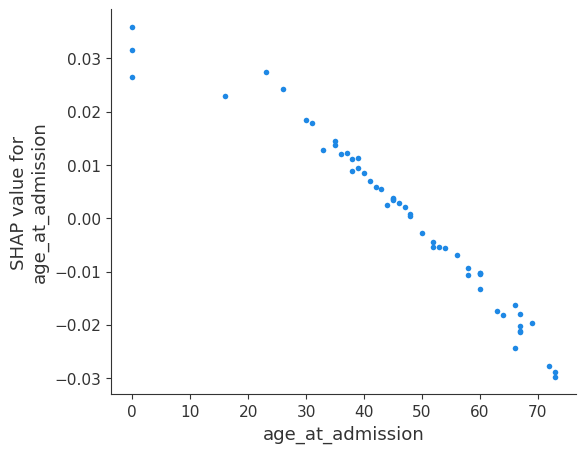


Generating SHAP dependence plot for feature: bilirubin_avg


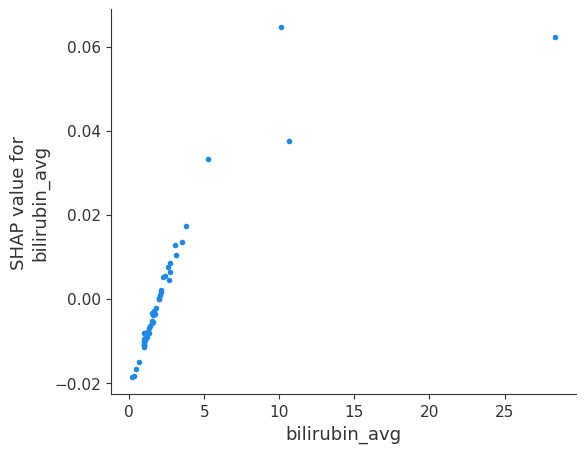


Generating SHAP dependence plot for feature: received_fentanyl


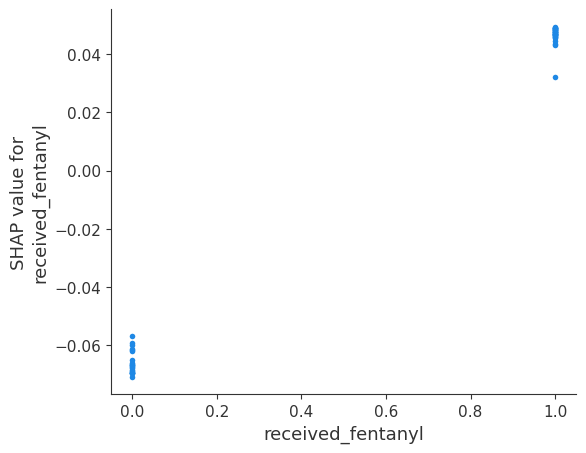

In [212]:
random.seed(42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scaling
    ('mlp', MLPClassifier())  # Step 3: MLP Classifier Model 
])
    
# Define parameter grid for hyperparameter tuning    
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'mlp__activation': ['tanh', 'relu', 'logistic'],
    'mlp__solver': ['adam', 'sgd', 'lbfgs'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 penalty (regularization term)
    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__max_iter': [200, 300, 500],
    'mlp__early_stopping': [True, False],
}

# Perform nested cross-validation to estimate generalization performance
print("Performing Nested Cross-Validation...")
start = time.time()

# Outer CV: Evaluating generalization performance
nested_scores = cross_val_score(
    RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10),
    X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1
)

end = time.time()
print(f"Nested CV completed in {end - start:.2f} seconds")
print("Nested Cross-Validated ROC AUC Score: %.2f ± %.2f" % (nested_scores.mean(), nested_scores.std()))


# Best model from grid search
end = time.time()
# Now train the final model on the full training data
print("\nTraining final model on full training set...")
grid_search = RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10)
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)

# Test set evaluation
print("\nEvaluating on Test Set...")
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Test Set ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Optional: Plotting (assuming you have Curve and Matrix functions)
Curve(y_test, y_prob)
Matrix(y_test, y_pred)

###############################################
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)
print(f"AUROC: %0.2f"%roc_auc)

# Add shap value table
mlp_model = best_pipeline.named_steps['mlp']
# Select X
Precision_Recall(best_pipeline, X_test, y_test)

if roc_auc > best_roc_auc:
    best_roc_auc = auc(fpr, tpr)
    pickle_model = best_pipeline
    best_y_pred = y_pred
    best_y_prob = y_prob
    best_classifier = best_pipeline.named_steps['mlp']
    best_X_train = X_train
    best_X_test = X_test

# Sample 100 instances for KernelExplainer background set
background = shap.sample(X_test, 100)

# Use full pipeline for predictions
print("Setting Kernel Explainer")
explainer = shap.KernelExplainer(pipeline_predict, background)

# Use a smaller sample for SHAP calculation (to keep it fast)
print("Setting Sample Data")
sample_data = X_test.iloc[:200]

# Compute SHAP values
print("Setting SHAP Values")
shap_values = explainer.shap_values(sample_data)

# Plot SHAP summary plot (for class 0 or 1; pick class 1 for binary classification)
print("Plotting SHAP summary")
print(shap_values[:,:,1].shape)
print(sample_data.shape)
plt.show()
shap.summary_plot(shap_values[:,:,1], sample_data)
plt.show()

# Optional: Dependence plots
print("Plotting SHAP values for each feature")
for feature in top_features:
    print(f"\nGenerating SHAP dependence plot for feature: {feature}")
    shap.dependence_plot(
        feature,
        shap_values[:,:,1],
        sample_data,
        interaction_index=None,
        show=True
    )

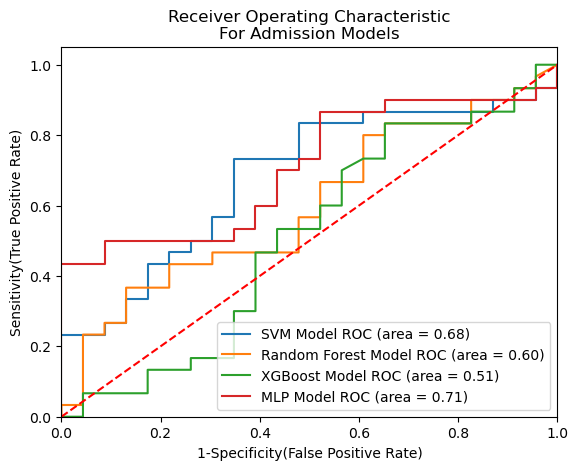

In [213]:
# Create AUC ROC Curve overlay
plt.plot(fpr_list[0], tpr_list[0], label ='%s ROC (area = %0.2f)' % ("SVM Model", roc_auc_list[0]))
plt.plot(fpr_list[1], tpr_list[1], label ='%s ROC (area = %0.2f)' % ("Random Forest Model", roc_auc_list[1]))
plt.plot(fpr_list[2], tpr_list[2], label ='%s ROC (area = %0.2f)' % ("XGBoost Model", roc_auc_list[2]))
plt.plot(fpr_list[3], tpr_list[3], label ='%s ROC (area = %0.2f)' % ("MLP Model", roc_auc_list[3]))

# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic\nFor Admission Models')
plt.legend(loc="lower right")
plt.show()   # Display